In [45]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,recall_score

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE


In [46]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")

# Separate features and label
X = df.drop("DEATH_EVENT", axis=1)
y = df["DEATH_EVENT"]

In [47]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [48]:
#Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check new balance
print("After SMOTE:", np.bincount(y_resampled))


After SMOTE: [203 203]


c:\Users\Morvica\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [49]:
scaler = StandardScaler()

In [50]:
X_scaled = scaler.fit_transform(X_resampled)

In [51]:
# Preprocessing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.2, random_state=42
)

In [52]:
#Train XGBoost with Class Weighting
model = XGBClassifier(scale_pos_weight=1.5, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [53]:
#Predict with Custom Threshold to Improve Recall
y_probs = model.predict_proba(X_test)[:, 1]
threshold = 0.4  # Try lowering to improve recall
y_pred = (y_probs > threshold).astype(int)



 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.85        41
           1       0.82      0.90      0.86        41

    accuracy                           0.85        82
   macro avg       0.86      0.85      0.85        82
weighted avg       0.86      0.85      0.85        82

Recall for Class 1 (Death): 0.9024390243902439
ROC AUC Score: 0.9321832242712671


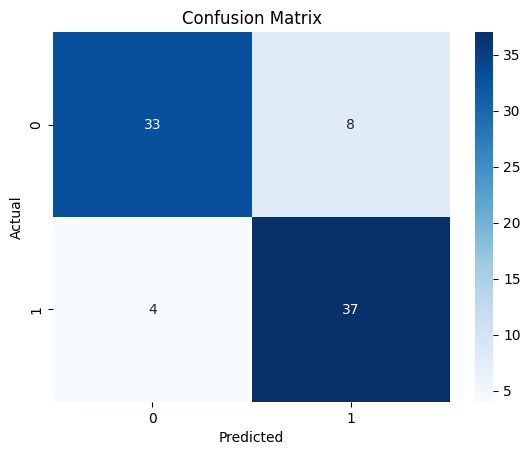

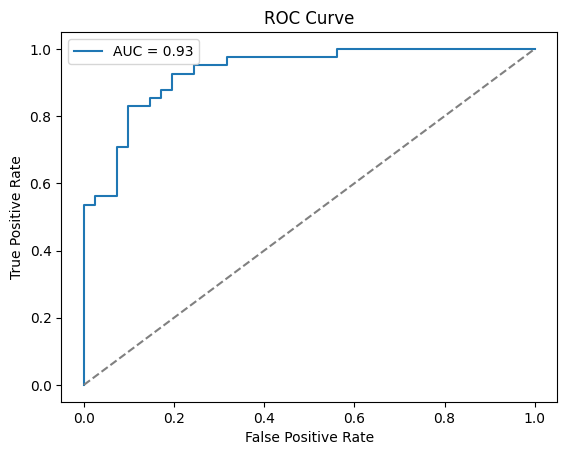

In [55]:
print("\n Classification Report:")
print(classification_report(y_test, y_pred))

print("Recall for Class 1 (Death):", recall_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_probs))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_probs):.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [56]:
#Train XGBoost Model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Save model and scaler
joblib.dump(model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")


c:\Users\Morvica\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [20:44:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['scaler.pkl']